In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, auc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

original = pd.read_csv("bank-full.csv", sep=";")
original['y'] = original['y'].apply(lambda x: 1 if x=="yes" else 0)

---

## Findings

- "day" can get encoded or transformed in some way since its not ratio data.  
- "pdays" has "-1" for missing data, otherwise is useful ratio data. Often people get called around quarter, half, full year

---

In [3]:
## convert day column to str so we will get target encoding as below

train['day'] = train['day'].astype(str)
original['day'] = original['day'].astype(str)

In [4]:
## convert 

---

In [5]:
# Step 1: Concatenate original + synthetic
train = pd.concat([train, original], ignore_index=True)

# Step 2: Categorical columns
cat_cols = original.select_dtypes(include=['object']).columns

# Step 3: Compute target means from original, and map to full train
for col in cat_cols:
    te_map = original.groupby(col)['y'].mean().to_dict()  # mean target per category
    train[col + "_mean"] = train[col].map(te_map)         # apply to full train
    #train.drop(columns=[col], inplace=True)

In [6]:
# create a column for pdays = -1

train['pdays_none'] = train['pdays'] == -1


train['pdays'] = train['pdays'].apply(lambda x: np.nan if x == -1 else x)

In [7]:
train['pdays_qtr_yr'] = ((train['pdays'] > 84) & (train['pdays'] < 96)).astype(int)
train['pdays_hlf_yr'] = ((train['pdays'] > 175) & (train['pdays'] < 190)).astype(int)
train['pdays_fl_yr'] = ((train['pdays'] > 359) & (train['pdays'] < 372)).astype(int)
train['pdays_mor_yr'] = ((train['pdays'] > 371)).astype(int)
train['pdays_none'] = (train['pdays'] == np.nan).astype(int)

In [8]:
train

,id,age,job,marital,education,default,balance,housing,loan,contact,...,loan_mean,contact_mean,day_mean,month_mean,poutcome_mean,pdays_none,pdays_qtr_yr,pdays_hlf_yr,pdays_fl_yr,pdays_mor_yr
0,0.0,42,technician,married,secondary,no,7,no,no,cellular,...,0.126557,0.149189,0.158333,0.110133,0.091615,0,0,0,0,0
1,1.0,38,blue-collar,married,secondary,no,514,no,no,unknown,...,0.126557,0.040707,0.098787,0.102228,0.091615,0,0,0,0,0
2,2.0,36,blue-collar,married,secondary,no,602,yes,no,unknown,...,0.126557,0.040707,0.113636,0.067195,0.091615,0,0,0,0,0
3,3.0,27,student,single,secondary,no,34,yes,no,unknown,...,0.126557,0.040707,0.078142,0.067195,0.091615,0,0,0,0,0
4,4.0,26,technician,married,secondary,no,889,yes,no,cellular,...,0.126557,0.149189,0.164968,0.166478,0.091615,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795206,NaN,51,technician,married,tertiary,no,825,no,no,cellular,...,0.126557,0.149189,0.090768,0.101511,0.091615,0,0,0,0,0
795207,NaN,71,retired,divorced,primary,no,1729,no,no,cellular,...,0.126557,0.149189,0.090768,0.101511,0.091615,0,0,0,0,0
795208,NaN,72,retired,married,secondary,no,5715,no,no,cellular,...,0.126557,0.149189,0.090768,0.101511,0.647253,0,0,1,0,0
795209,NaN,57,blue-collar,married,secondary,no,668,no,no,telephone,...,0.126557,0.134205,0.090768,0.101511,0.091615,0,0,0,0,0


---

In [9]:
# Assuming x_train is your DataFrame of features
categorical_features_names = train.select_dtypes(include=['object', 'category']).columns.tolist()

# Make sure 'remainder__MSZoning' is in this list. It should be if its dtype is object.
print("Detected categorical features:", categorical_features_names)

Detected categorical features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome']


In [10]:
import json
import optuna

# Load the best parameters from the saved file
try:
    with open("models/optuna_cat1.json", "r") as f:
        best_params = json.load(f)
    print("Successfully loaded best parameters:")
    print(best_params)
except FileNotFoundError:
    print("Error: The file 'best_params.json' was not found.")

Successfully loaded best parameters:
{'depth': 7, 'learning_rate': 0.16242304317665213, 'l2_leaf_reg': 9.784139225596583, 'iterations': 991, 'subsample': 0.6576101811374836}


In [12]:
best_params

{'depth': 7,
 'learning_rate': 0.16242304317665213,
 'l2_leaf_reg': 9.784139225596583,
 'iterations': 991,
 'subsample': 0.6576101811374836}

### Catboost params optuna:

```p
{'depth': 7, 'learning_rate': 0.21305454563600107, 'l2_leaf_reg': 8.835313767106186, 'iterations': 1390, 'subsample': 0.9895304489914225}

In [18]:
cat_days_enc = CatBoostClassifier(**best_params, cat_features=categorical_features_names)

cat_days_enc.fit(train.drop(columns=['y','id']), train['y'])

KeyboardInterrupt: 

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import numpy as np

def objective(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "verbose": 0,
        "depth": trial.suggest_int("depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.01, 10.0),
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
    }

    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(x_train, y_train):
        X_train_cv, X_valid_cv = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = CatBoostClassifier(**params, cat_features=categorical_features_names)
        model.fit(X_train_cv, y_train_cv)

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        aucs.append(auc)

    return np.mean(aucs)


In [ ]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)


In [ ]:
optuna_best_model = CatBoostClassifier(**study.best_params, cat_features=categorical_features_names)

In [ ]:
import json

# Your existing Optuna code
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=40)

print("Best Params:", study.best_params)

# Save the best parameters to a JSON file
with open("models/optuna_cat2_targetenc.json", "w") as f:
    json.dump(study.best_params, f, indent=4)

print("Best parameters saved to 'best_params.json'")

---

In [171]:
import xgboost as xgb

x_train = train.drop(columns=['y','id'])
y_train = train['y']


def objective(trial):
    params = {
        "eval_metric": "auc",
        "max_depth": trial.suggest_int("max_depth", 6, 22),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5),
        "n_estimators": trial.suggest_int("n_estimators", 400, 2200),
        "subsample": trial.suggest_float("subsample", 0.01, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.01, 1.0),
        "reg_lambda": trial.suggest_float("lambda", 0.01, 20.0),
        "reg_alpha": trial.suggest_float("alpha", 0.01, 10.0),
        "gamma": trial.suggest_float("gamma", 0.01, 10.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_delta_step": trial.suggest_int("max_delta_step", 0, 10),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.01, 10.0),
        "base_score": trial.suggest_float("base_score", 0.000001, 0.999999),
        "tree_method": "auto",
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []

    for train_idx, valid_idx in cv.split(x_train, y_train):
        X_train_cv, X_valid_cv = x_train.iloc[train_idx], x_train.iloc[valid_idx]
        y_train_cv, y_valid_cv = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_train_cv, y_train_cv, verbose=1)

        preds = model.predict_proba(X_valid_cv)[:, 1]
        auc = roc_auc_score(y_valid_cv, preds)
        aucs.append(auc)

    return np.mean(aucs)


In [172]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=33)

print("Best AUC:", study.best_value)
print("Best Params:", study.best_params)

[I 2025-08-10 17:59:26,377] A new study created in memory with name: no-name-2b6109f4-3e60-43b6-b8b3-347a8e135809


[I 2025-08-10 18:01:11,322] Trial 0 finished with value: 0.953292345876165 and parameters: {'max_depth': 15, 'learning_rate': 0.07169934698898674, 'n_estimators': 2091, 'subsample': 0.49661432227180347, 'colsample_bytree': 0.24759185970785758, 'lambda': 16.235980360472883, 'alpha': 4.657142583228518, 'gamma': 4.504083817902987, 'min_child_weight': 7, 'max_delta_step': 10, 'scale_pos_weight': 0.04714501767939613, 'base_score': 0.8202497127078892}. Best is trial 0 with value: 0.953292345876165.
[I 2025-08-10 18:03:08,765] Trial 1 finished with value: 0.9652527226771696 and parameters: {'max_depth': 22, 'learning_rate': 0.13173901265720173, 'n_estimators': 1466, 'subsample': 0.9544085473857095, 'colsample_bytree': 0.7303828481395733, 'lambda': 9.56291034626154, 'alpha': 2.64289826665425, 'gamma': 1.6398246593278638, 'min_child_weight': 9, 'max_delta_step': 1, 'scale_pos_weight': 9.494033986216651, 'base_score': 0.10028647463255344}. Best is trial 1 with value: 0.9652527226771696.
[I 2025-

Best AUC: 0.9665176586242051
Best Params: {'max_depth': 19, 'learning_rate': 0.06713653207413413, 'n_estimators': 636, 'subsample': 0.5601215682958539, 'colsample_bytree': 0.4945498077523225, 'lambda': 3.4532262397491, 'alpha': 7.945588384011887, 'gamma': 2.420721931747102, 'min_child_weight': 3, 'max_delta_step': 8, 'scale_pos_weight': 1.5860211429131792, 'base_score': 0.32509992019090567}


In [53]:
optuna_xgb =  xgb.XGBClassifier(max_depth = 11, learning_rate = 0.11054441560306486, n_estimators = 968, subsample = 0.886000523994339, colsample_bytree = 0.8861307860051247, reg_lambda = 6.272903605223428, reg_alpha = 9.885145393550097, gamma = 0.7453177239456863, min_child_weight = 4, max_delta_step = 9, scale_pos_weight = 4.672701653124035, base_score = 0.17657410135549562)

In [174]:
optuna_xgb = xgb.XGBClassifier(**study.best_params)

In [185]:
study.best_params

{'max_depth': 19,
 'learning_rate': 0.06713653207413413,
 'n_estimators': 636,
 'subsample': 0.5601215682958539,
 'colsample_bytree': 0.4945498077523225,
 'lambda': 3.4532262397491,
 'alpha': 7.945588384011887,
 'gamma': 2.420721931747102,
 'min_child_weight': 3,
 'max_delta_step': 8,
 'scale_pos_weight': 1.5860211429131792,
 'base_score': 0.32509992019090567}

In [176]:
optuna_xgb.fit(x_train, y_train)

KeyboardInterrupt: 

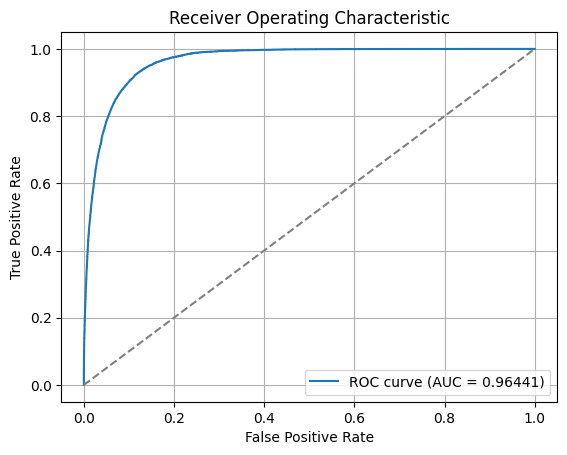

In [55]:
optuna_prob = cat_days_enc.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, optuna_prob[:,1])

roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()

In [177]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
aucs = []

for train_idx, valid_idx in cv.split(train.drop(columns=['y','id']), train['y']):
    X_tr, X_val = train.drop(columns=['y','id']).iloc[train_idx], train.drop(columns=['y','id']).iloc[valid_idx]
    y_tr, y_val = train['y'].iloc[train_idx], train['y'].iloc[valid_idx]

    model = xgb.XGBClassifier(**study.best_params)
    model.fit(X_tr, y_tr, verbose=1)
    
    preds = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, preds)
    aucs.append(auc)

final_auc = np.mean(aucs)
print("Final AUC:", final_auc)

Final AUC: 0.9668479500854131


In [178]:
train

,id,age,balance,duration,campaign,pdays,previous,y,job_mean,marital_mean,...,loan_mean,contact_mean,day_mean,month_mean,poutcome_mean,pdays_none,pdays_qtr_yr,pdays_hlf_yr,pdays_fl_yr,pdays_mor_yr
0,0.0,42,7,117,3,NaN,0,0,0.110570,0.101235,...,0.126557,0.149189,0.158333,0.110133,0.091615,0,0,0,0,0
1,1.0,38,514,185,1,NaN,0,0,0.072750,0.101235,...,0.126557,0.040707,0.098787,0.102228,0.091615,0,0,0,0,0
2,2.0,36,602,111,2,NaN,0,0,0.072750,0.101235,...,0.126557,0.040707,0.113636,0.067195,0.091615,0,0,0,0,0
3,3.0,27,34,10,2,NaN,0,0,0.286780,0.149492,...,0.126557,0.040707,0.078142,0.067195,0.091615,0,0,0,0,0
4,4.0,26,889,902,1,NaN,0,1,0.110570,0.101235,...,0.126557,0.149189,0.164968,0.166478,0.091615,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795206,NaN,51,825,977,3,NaN,0,1,0.110570,0.101235,...,0.126557,0.149189,0.090768,0.101511,0.091615,0,0,0,0,0
795207,NaN,71,1729,456,2,NaN,0,1,0.227915,0.119455,...,0.126557,0.149189,0.090768,0.101511,0.091615,0,0,0,0,0
795208,NaN,72,5715,1127,5,184.0,3,1,0.227915,0.101235,...,0.126557,0.149189,0.090768,0.101511,0.647253,0,0,1,0,0
795209,NaN,57,668,508,4,NaN,0,0,0.072750,0.101235,...,0.126557,0.134205,0.090768,0.101511,0.091615,0,0,0,0,0


In [102]:
train['pdays_qtr_yr'] = ((train['pdays'] > 86) & (train['pdays'] < 94)).astype(int)
train['pdays_hlf_yr'] = ((train['pdays'] > 178) & (train['pdays'] < 187)).astype(int)
train['pdays_fl_yr'] = ((train['pdays'] > 361) & (train['pdays'] < 369)).astype(int)
train['pdays_mor_yr'] = ((train['pdays'] > 370)).astype(int)
train['pdays_none'] = (train['pdays'] == -1).astype(int)

In [144]:
model = xgb.XGBClassifier(**study.best_params)

model.fit(train.drop(columns=['y','id']), train['y'])

XGBClassifier(alpha=9.885145393550097, base_score=0.17657410135549562,
              booster=None, callbacks=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.8861307860051247,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=0.7453177239456863, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=6.272903605223428,
              learning_rate=0.11054441560306486, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=9,
              max_depth=11, max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=968, ...)

In [148]:
model.feature_names_in_

array(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'job_mean', 'marital_mean', 'education_mean', 'default_mean',
       'housing_mean', 'loan_mean', 'contact_mean', 'day_mean',
       'month_mean', 'poutcome_mean', 'pdays_none', 'pdays_qtr_yr',
       'pdays_hlf_yr', 'pdays_fl_yr', 'pdays_mor_yr'], dtype='<U14')

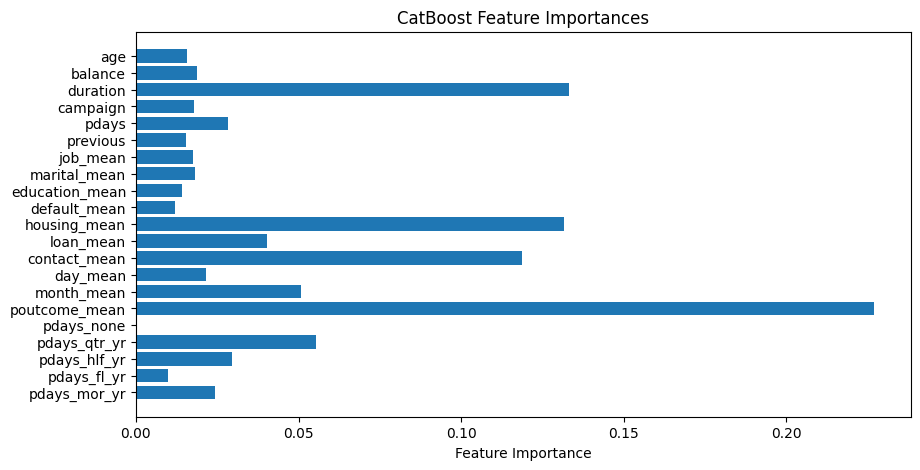

In [179]:
importances = model.feature_importances_

feature_names = model.feature_names_in_

plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("CatBoost Feature Importances")
plt.gca().invert_yaxis()
plt.show()


In [14]:
test['pdays_qtr_yr'] = ((test['pdays'] > 86) & (test['pdays'] < 94)).astype(int)
test['pdays_hlf_yr'] = ((test['pdays'] > 178) & (test['pdays'] < 187)).astype(int)
test['pdays_fl_yr'] = ((test['pdays'] > 361) & (test['pdays'] < 369)).astype(int)
test['pdays_mor_yr'] = ((test['pdays'] > 370)).astype(int)
test['pdays_none'] = (test['pdays'] == np.nan).astype(int)

In [13]:
## convert day column to str so we will get target encoding as below

test['day'] = test['day'].astype(str)
original['day'] = original['day'].astype(str)

# Step 1: Concatenate original + synthetic
test = pd.concat([test, original], ignore_index=True)

# Step 2: Categorical columns
cat_cols = original.select_dtypes(include=['object']).columns

# Step 3: Compute target means from original, and map to full train
for col in cat_cols:
    te_map = original.groupby(col)['y'].mean().to_dict()  # mean target per category
    test[col + "_mean"] = test[col].map(te_map)         # apply to full train
    #test.drop(columns=[col], inplace=True)
test['pdays_none'] = test['pdays'] == -1


test['pdays'] = test['pdays'].apply(lambda x: np.nan if x == -1 else x)

In [15]:
test_prep = test.drop(columns = ['y']).dropna(subset = ['id'])

test_id = test_prep['id']

probas = cat_days_enc.predict_proba(test_prep.drop(columns = ['id']))

In [16]:
sub_df = pd.DataFrame({'id': test_id, 'y': probas[:,1]})

In [17]:
sub_df.to_csv("submissions/cat_pdays_split.csv", index=False)

In [89]:
sub_df.reindex()

,id,y
0,750000,0.001489
1,750001,0.086486
2,750002,0.000331
3,750003,0.000028
4,750004,0.009014
...,...,...
249995,999995,0.000051
249996,999996,0.188738
249997,999997,0.932505
249998,999998,0.000501


In [88]:
pd.read_csv("submissions/cat_optuna_tuned.csv")

,id,y
0,750000,0.003198
1,750001,0.140897
2,750002,0.000168
3,750003,0.000029
4,750004,0.023949
...,...,...
249995,999995,0.000271
249996,999996,0.109660
249997,999997,0.423618
249998,999998,0.000915


In [186]:
pd.read_csv("log.csv")

,date,model_name,features,cv_auc,public_lb,hparams,notes
0,08/08/25,xgboost,"""target encoding using og dataset; put nans i...",0.970570,0.96411,{max_depth = 11; learning_rate = 0.1105; n_es...,NaN
1,09/08/25,xgboost,as above. pdays features for qtr; hlf; fll yr,0.965578,0.96827,as above,should run optuna with new dataset; new featu...
2,10/08/25,xgboost optuna tuned,target encoded with og data and split pdays,0.966848,0.96928,('max_depth': 19; 'learning_rate': 0.06713653...,None
